#### In this notebook, dimensionality of features is reduced using simple PCA and linear models are trained to predict energies.

#### Import some required libraries

In [83]:

## Standard libraries
import numpy as np
import pandas as pd
import os
import pickle

## For some analysis
import MDAnalysis as mda
from MDAnalysis.analysis import distances

## For plotting
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.gridspec import GridSpec

## For visualization
import nglview as nv

## For some data pre-processing
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA, KernelPCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


#### Global matplot font settings

In [3]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

#### Read features: This is input x.

In [6]:

# Save features to memory
feature_distances_file = './data/features_intra_distances.npy'
        
feature_distances = np.load(feature_distances_file)
feature_distances = np.array(feature_distances)


#### Read output energies. This is y.

In [7]:
#### Load PBE energies

pbe_energies = pd.read_csv('data/energies.txt', comment="#", 
                           names=['structure', 'energy'], 
                           delim_whitespace=True)


#### Scale input features and output values. This is to make sure they are on the same scale or normalized. 

In [17]:
#### Scale the input features to the range 0 to 1
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(feature_distances)
    
scaled_features = scaler.transform(feature_distances)
scaled_features = np.array(scaled_features)
    
# Scale output energies to the range -1 to 1.
y_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_scaler.fit(pbe_energies.energy.values.reshape(-1,1))
y_scaled = y_scaler.transform(pbe_energies.energy.values.reshape(-1,1))
y_scaled = np.array(y_scaled)


#### save scaler

In [77]:
# Save the scaler to a file
with open('./data/x_minmax_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
with open('./data/y_minmax_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)

#### Data checks: Check distribution of output energy and scaled output energy.

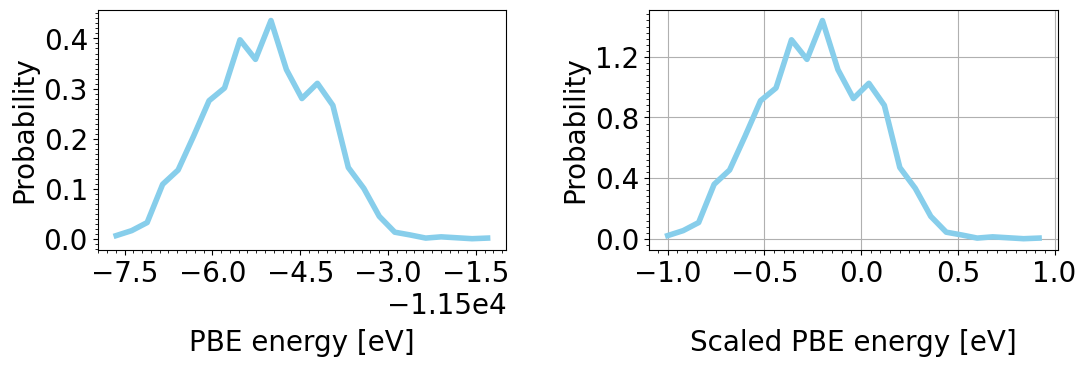

In [19]:

# Set the figure size
fig = plt.figure(figsize=(12, 3))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.35, hspace=0.35)

grid = GridSpec(1, 2)

ax = plt.subplot(grid[0, 0])

hist, bins = np.histogram(pbe_energies.energy.values, bins=25, density=True)  
ax.plot(bins[:-1], hist, color='skyblue', lw=4)

ax.set_xlabel('PBE energy [eV]', labelpad=30)
ax.set_ylabel('Probability')

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))

ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))


ax = plt.subplot(grid[0, 1])

hist, bins = np.histogram(y_scaled, bins=25, density=True)  
ax.plot(bins[:-1], hist, color='skyblue', lw=4)

ax.set_xlabel('Scaled PBE energy [eV]', labelpad=30)
ax.set_ylabel('Probability')

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))

ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))


plt.grid(True)

#### Perform dimensionality reduction using PCA

In [23]:

pca = PCA() 
features_pca = pca.fit_transform(scaled_features)

print(features_pca.shape)


(6095, 171)


#### Check fraction of variance explained.

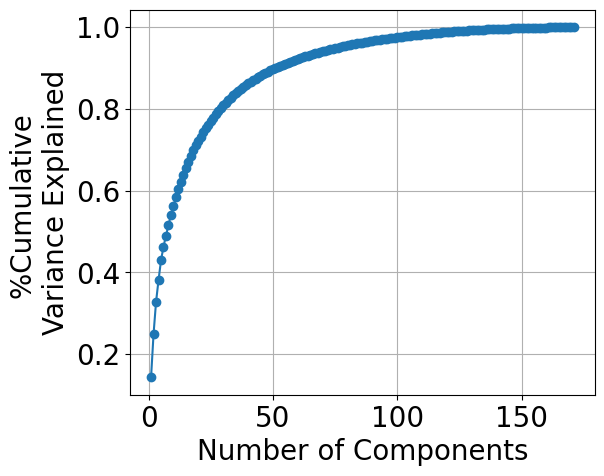

In [30]:
# Get the explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

fig = plt.figure(figsize=(6, 5))
# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

plt.xlabel('Number of Components')
plt.ylabel('%Cumulative \nVariance Explained')
#plt.axvline(x=2, lw=1, color='red')
plt.grid(True)
plt.show()





#### Clearly, ~90-100 components are requried to explain ~95% of cumulative variance. However, this is okay as it atleast removes the linear covariances between the input features. Perhaps a non-linear dimensionality reduction (dMaps, kernelPCA) could help in reducing the dimensions further depending on the extent of non-linear covariances but for this workshop we focus on just PCA.


#### check distribution of PCA projections

/tmp/ipykernel_273324/2747076771.py:37: RuntimeWarning: divide by zero encountered in log
  cb = ax.contourf(xedges[:-1], yedges[:-1], np.log(hist.T), cmap='inferno')


Plotting PC[(0, 1)] in subplot[0]
Plotting PC[(0, 2)] in subplot[1]
Plotting PC[(0, 3)] in subplot[2]
Plotting PC[(0, 4)] in subplot[3]
Plotting PC[(1, 2)] in subplot[4]
Plotting PC[(1, 3)] in subplot[5]
Plotting PC[(1, 4)] in subplot[6]
Plotting PC[(2, 3)] in subplot[7]
Plotting PC[(2, 4)] in subplot[8]
Plotting PC[(3, 4)] in subplot[9]


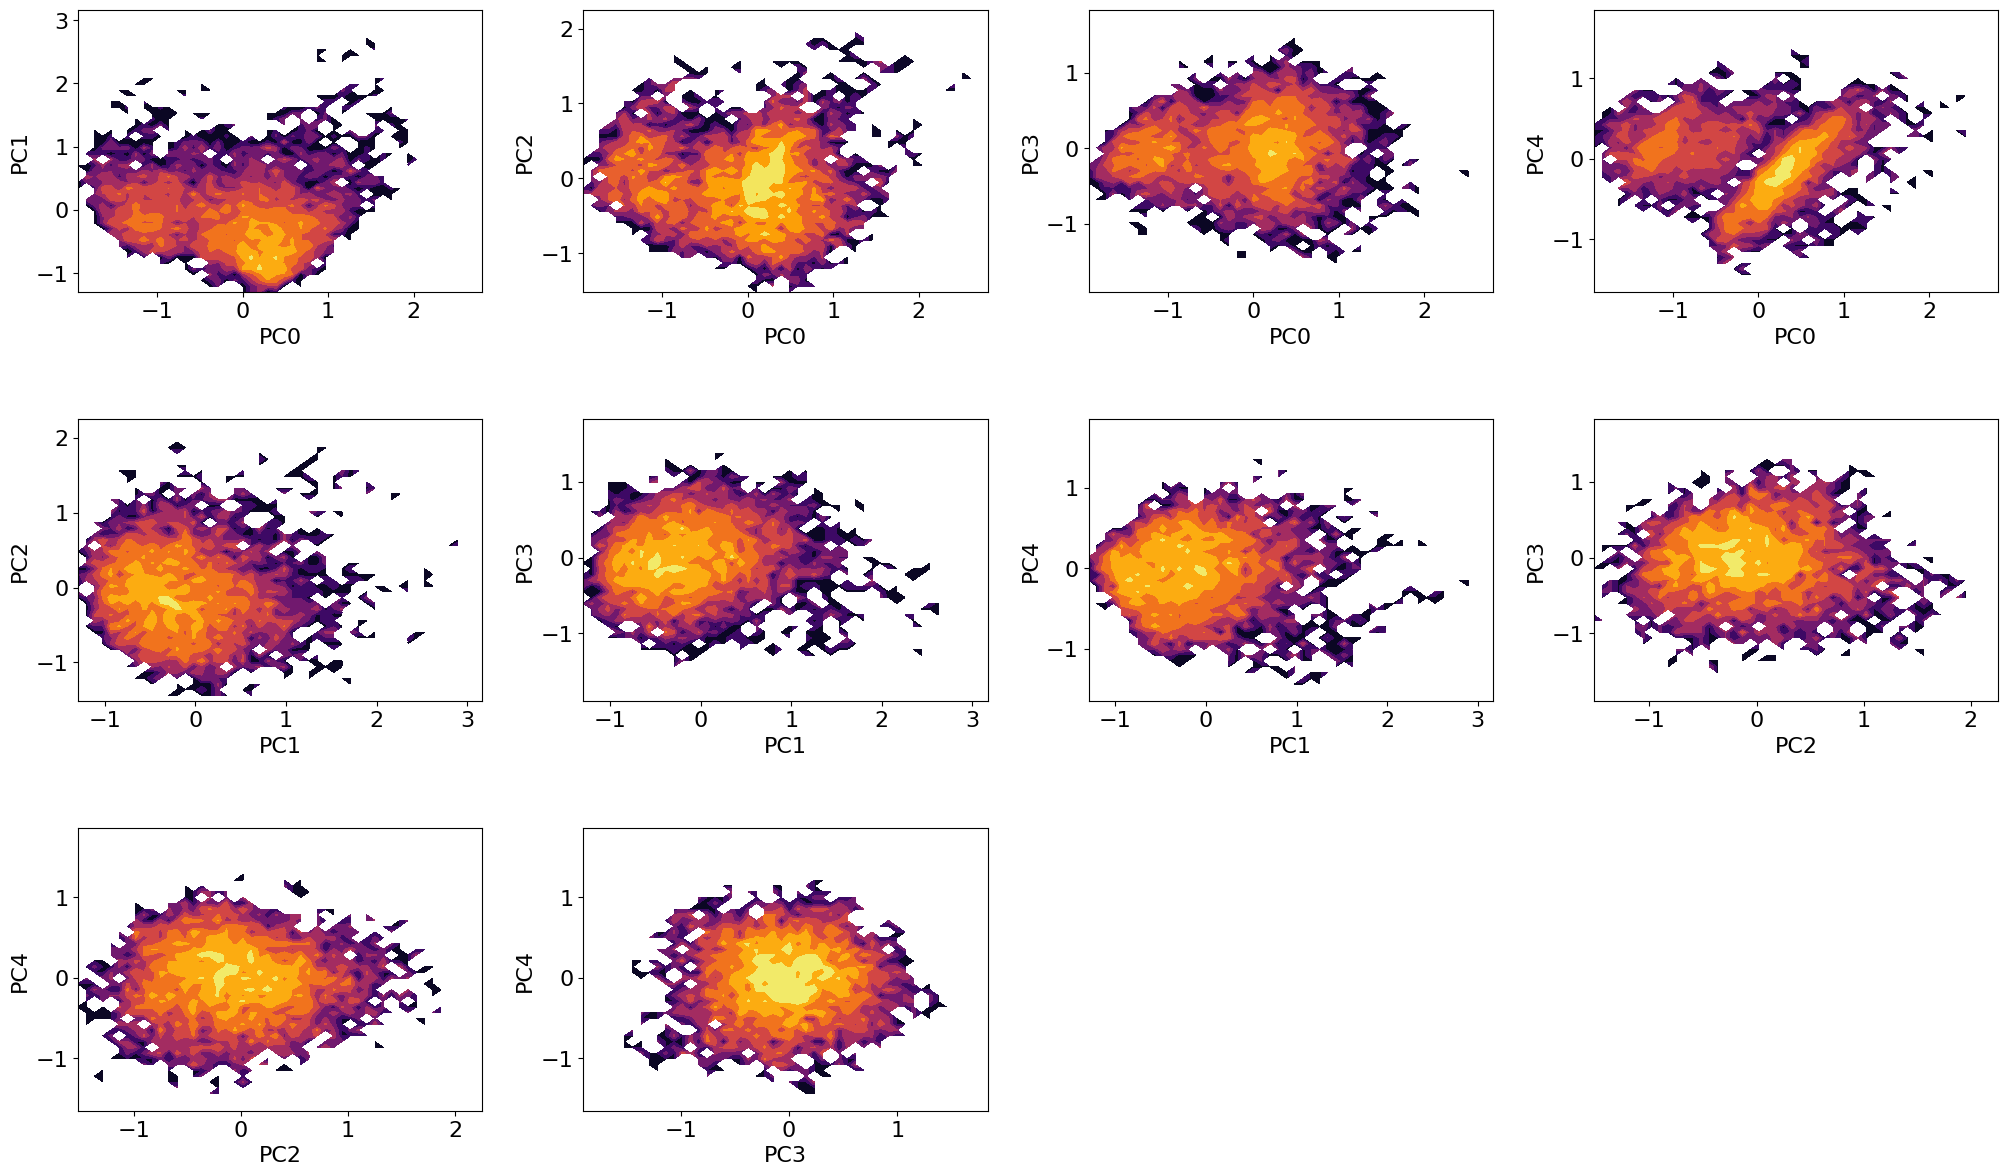

In [37]:
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
    
# Set the figure size
fig = plt.figure(figsize=(24, 24))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.25, hspace=0.45)

nrows=5
ncols=4

# Create a 3x3 grid
grid = GridSpec(nrows, ncols)

# generate pairs for looping through subplots
axes_pairs = {}
count_ij = 0
for i in range(nrows):
    for j in range(ncols):
        axes_pairs[count_ij] = [i,j]
        count_ij += 1

#print(axes_pairs)
count_ij = 0
for j in range(ncols): 
    for i in range(nrows): 
        
        if i > j:
            ax = plt.subplot(grid[axes_pairs[count_ij][0], axes_pairs[count_ij][1]])
            
            
            # Create a 2D histogram
            hist, xedges, yedges = np.histogram2d(features_pca[:,j].flatten(), features_pca[:,i].flatten(), 
                                                  bins=50, density=True)
            cb = ax.contourf(xedges[:-1], yedges[:-1], np.log(hist.T), cmap='inferno')

            ax.set_xlabel('PC'+str(j))
            ax.set_ylabel('PC'+str(i))
                
#             #ax.yaxis.set_major_locator(MultipleLocator(0.1))
#             #ax.xaxis.set_major_locator(MultipleLocator(0.2))
#             ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
#             ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))

            print(f'Plotting PC[{j,i}] in subplot[{count_ij}]')

            count_ij += 1


#### Split data into training and test data

In [81]:
# for extracting indices; convert the features in dataframes
X=features_pca
y=y_scaled.flatten()
X = pd.DataFrame(X, columns=[(' '.join('pc'+str(i) for i in range(X.shape[-1]))).split()])
y = pd.Series(y)

# pca features
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# distance features i.e., before applying PCA
X_train_dist, X_test_dist = scaled_features[X_train.index], scaled_features[X_test.index]


RangeIndex(start=0, stop=6095, step=1)

#### save training and test data

In [82]:
#### 

# Save features to memory
pca_train_test_file = './data/x_features_y_labels.npy'
        
if not os.path.exists(pca_train_test_file):

    # Save the scaler to a file
    with open(pca_train_test_file, 'wb') as f:
        
        pickle.dump({'pca_X_train': X_train, 'pca_X_test': X_test, 'y_train': y_train, 'y_test': y_test,
                     'X_train': X_train_dist, 'X_test': X_test_dist}, f)
        
        

#### Train a linear model to predict PBE energies given the location of structure in PC space

In [116]:

#### Create a linear regression model
linear_model = LinearRegression()

# Set number of dimensions of PC to use as features
ndim=150

linear_model.fit(X_train.values[:,:ndim], y_train)

# Step 5: Evaluate the model
linear_train_y_pred = linear_model.predict(X_train.values[:,:ndim])
linear_test_y_pred = linear_model.predict(X_test.values[:,:ndim])

print(f"Linear MSE: Train:{mean_squared_error(y_train, linear_train_y_pred)}, Test:{mean_squared_error(y_test, linear_test_y_pred)}")
train_r2=r2_score(y_train, linear_train_y_pred)
test_r2=r2_score(y_test, linear_test_y_pred)
print(f"Linear R2: Train:{train_r2}, Test:{test_r2}")


Linear MSE: Train:0.03995482251083257, Test:0.04396672522696959
Linear R2: Train:0.5037004501049999, Test:0.4786997662338869


#### Visualize the results

#### Parity plot of ground truth and predictions in train and test 

Text(0, 0.5, 'Predicted (eV)')

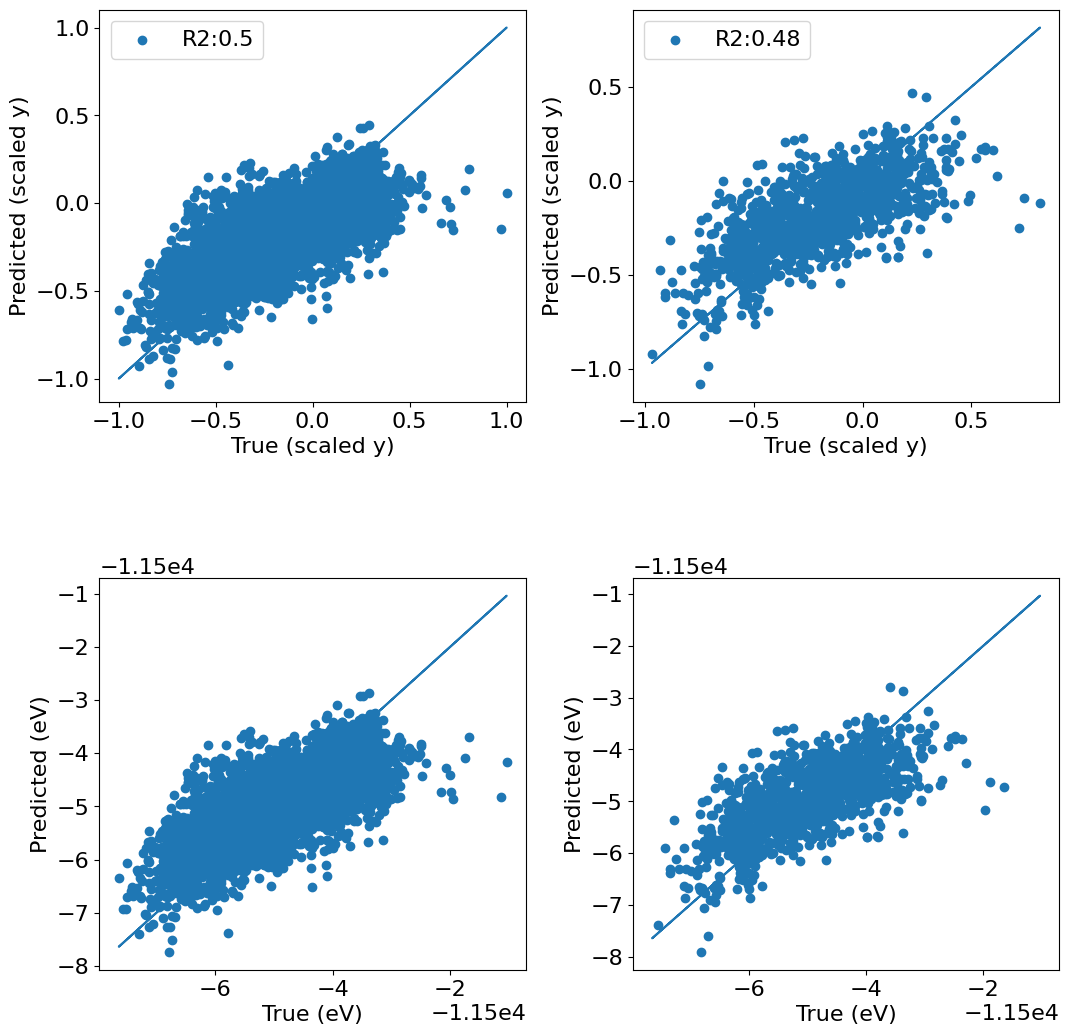

In [117]:
# Set the figure size
fig = plt.figure(figsize=(12, 12))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.25, hspace=0.45)

nrows=2
ncols=2

# Create a 3x3 grid
grid = GridSpec(nrows, ncols)

ax = plt.subplot(grid[0,0])

ax.scatter(y_train, linear_train_y_pred, label=f'R2:{np.round(train_r2,2)}')
ax.plot(y_train, y_train)

ax.set_xlabel('True (scaled y)')
ax.set_ylabel('Predicted (scaled y)')
ax.legend()

ax = plt.subplot(grid[0,1])

ax.scatter(y_test, linear_test_y_pred,label=f'R2:{np.round(test_r2,2)}')
ax.plot(y_test, y_test)

ax.set_xlabel('True (scaled y)')
ax.set_ylabel('Predicted (scaled y)')
ax.legend()



ax = plt.subplot(grid[1,0])

ax.scatter(y_scaler.inverse_transform(y_train.values.reshape(-1,1)), 
           y_scaler.inverse_transform(linear_train_y_pred.reshape(-1,1)))
ax.plot(y_scaler.inverse_transform(y_train.values.reshape(-1,1)), 
        y_scaler.inverse_transform(y_train.values.reshape(-1,1)))

ax.set_xlabel('True (eV)')
ax.set_ylabel('Predicted (eV)')

ax = plt.subplot(grid[1,1])

ax.scatter(y_scaler.inverse_transform(y_test.values.reshape(-1,1)), 
           y_scaler.inverse_transform(linear_test_y_pred.reshape(-1,1)))
ax.plot(y_scaler.inverse_transform(y_train.values.reshape(-1,1)), 
        y_scaler.inverse_transform(y_train.values.reshape(-1,1)))

ax.set_xlabel('True (eV)')
ax.set_ylabel('Predicted (eV)')




#### true values and predicted values against each dimension [scaled values; can be inverted easily]

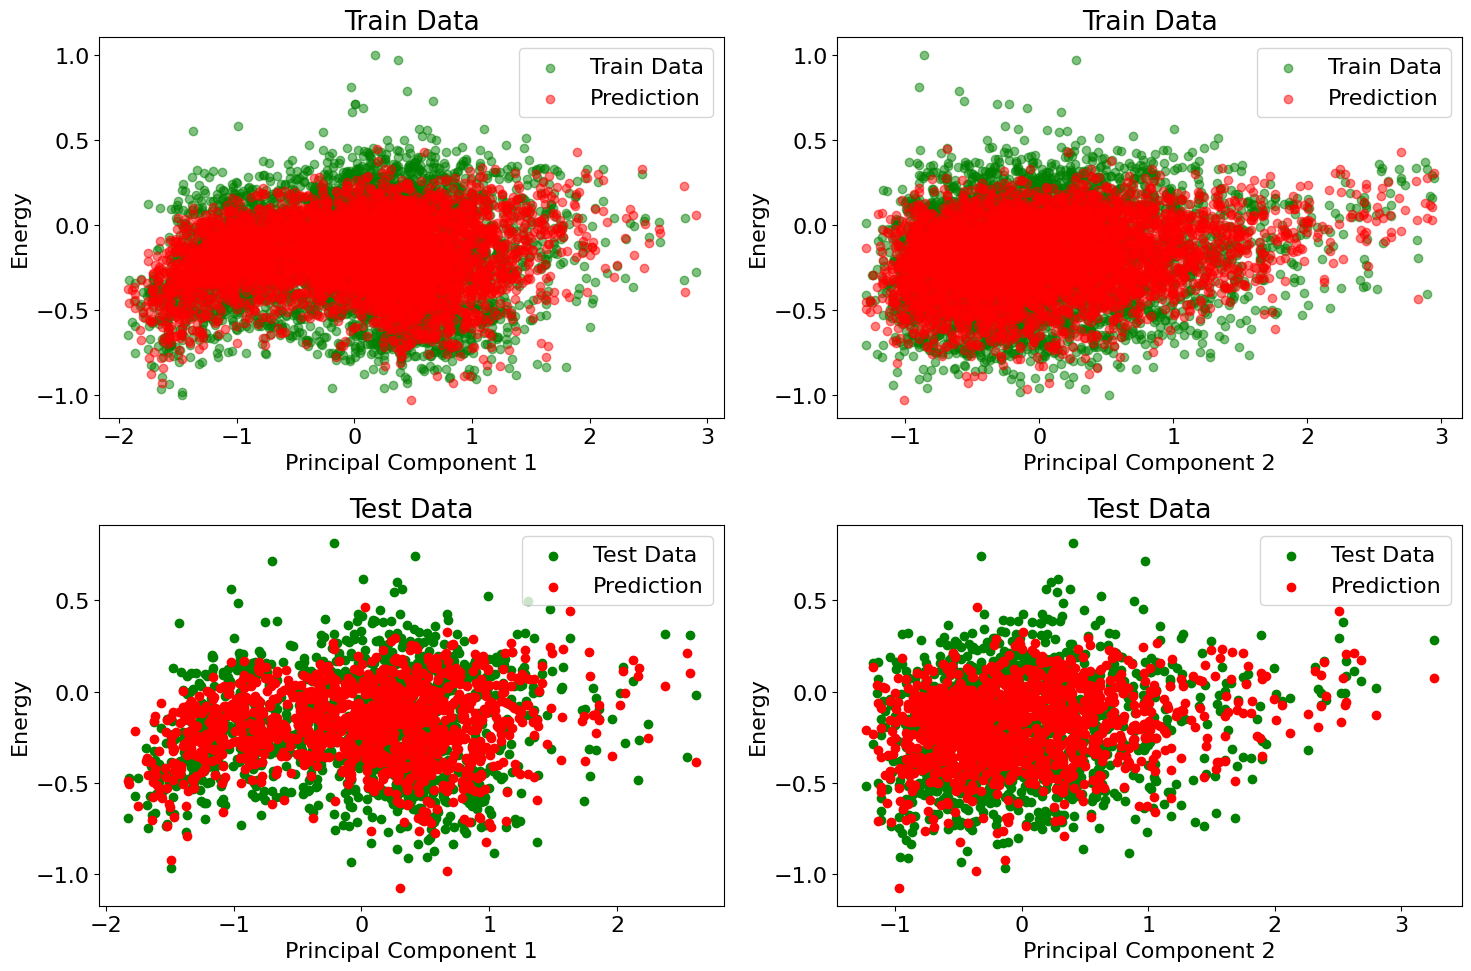

In [121]:

# Plot y values against each principal component for both train and test data
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i in range(2):
    # Train data
    axs[0, i].scatter(X_train.values[:, i], y_train, color='green', label='Train Data', alpha=0.5)
    axs[0, i].scatter(X_train.values[:, i], linear_train_y_pred, color='red', label='Prediction', alpha=0.5)
    
    axs[0, i].set_xlabel(f'Principal Component {i+1}')
    axs[0, i].set_ylabel('Energy')
    axs[0, i].set_title('Train Data')
    
    axs[0, i].legend()

    # Test data
    axs[1, i].scatter(X_test.values[:, i], y_test, color='green', label='Test Data')
    axs[1, i].scatter(X_test.values[:, i], linear_test_y_pred, color='red', label='Prediction')
    
    axs[1, i].set_xlabel(f'Principal Component {i+1}')
    axs[1, i].set_ylabel('Energy')
    axs[1, i].set_title('Test Data')
    
    axs[1, i].legend()

plt.tight_layout()
plt.show()

#### true values and predicted values against two dimensions at a time [scaled values; can be inverted easily]

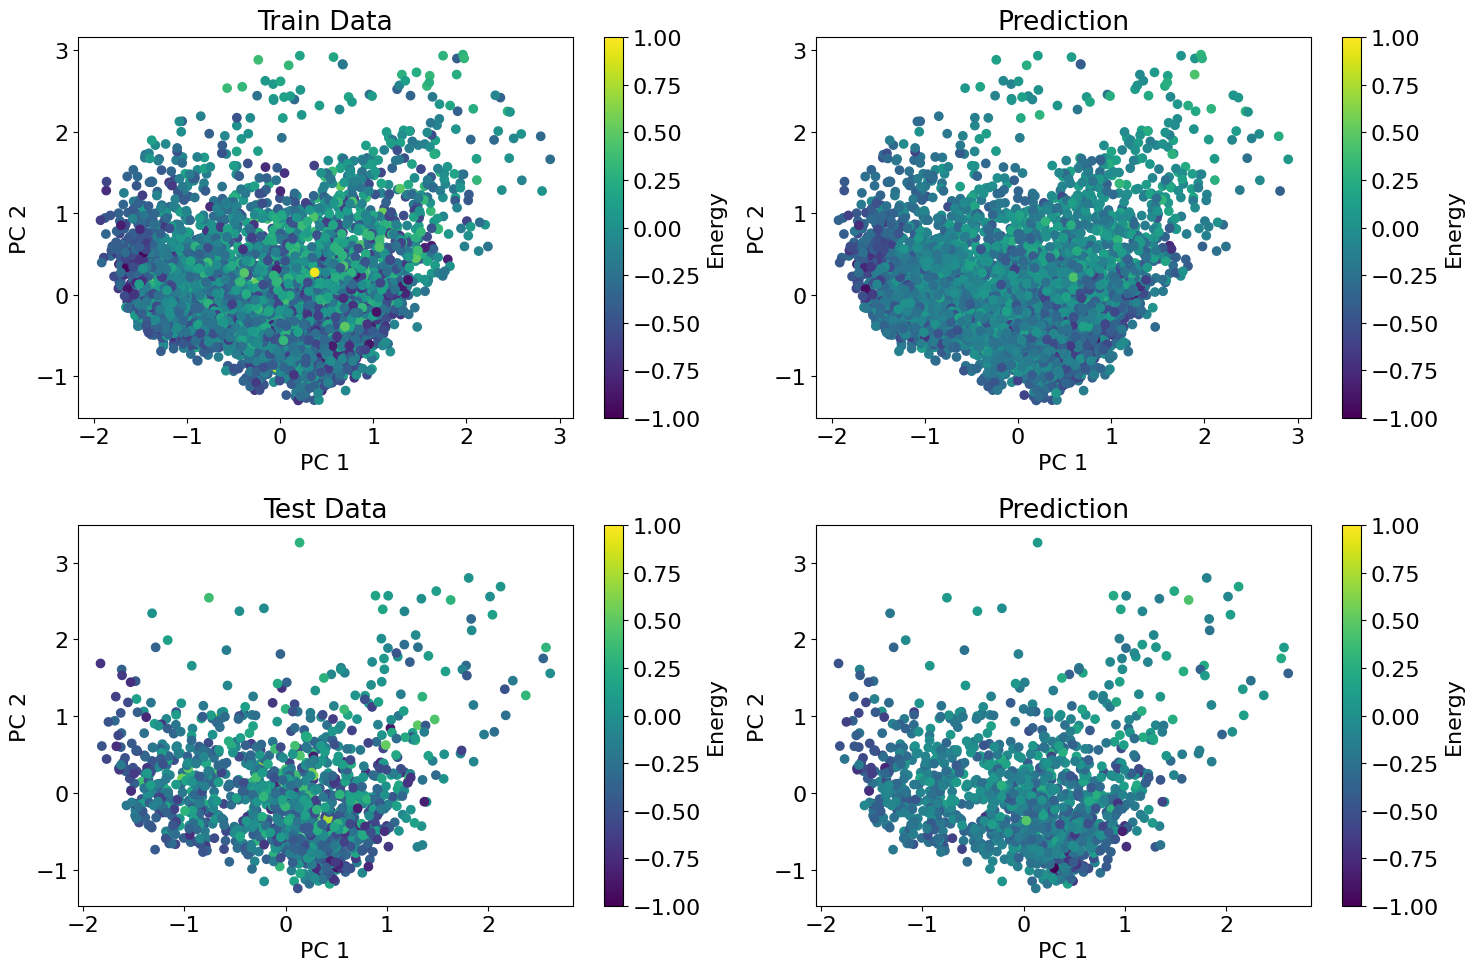

In [130]:

def plot_scatter_with_color(ax, x1, x2, y, title, vmin, vmax, select_pc1, select_pc2):
    scatter = ax.scatter(x1, x2, c=y, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_xlabel('PC '+str(select_pc1+1))
    ax.set_ylabel('PC '+str(select_pc2+1))
    ax.set_title(title)
    #ax.legend()
    plt.colorbar(scatter, ax=ax, label='Energy')

# Create subplots for train and test data
fig, axs = plt.subplots(2, 2, figsize=(15, 10))


select_pc1 = 0
select_pc2 = 1

# Plot train data
plot_scatter_with_color(axs[0, 0], X_train.values[:, select_pc1], X_train.values[:, select_pc2], 
                        y_train, 'Train Data', y_train.min(), y_train.max(), select_pc1, select_pc2)
plot_scatter_with_color(axs[0, 1], X_train.values[:, select_pc1], X_train.values[:, select_pc2], 
                        linear_train_y_pred, 'Prediction', y_train.min(), 
                        y_train.max(), select_pc1, select_pc2)




# Plot test data
plot_scatter_with_color(axs[1, 0], X_test.values[:, select_pc1], X_test.values[:, select_pc2], 
                        y_test, 'Test Data', 
                        y_train.min(), y_train.max(), select_pc1, select_pc2)
plot_scatter_with_color(axs[1, 1], X_test.values[:, select_pc1], X_test.values[:, select_pc2], 
                        linear_test_y_pred, 'Prediction',
                        y_train.min(), y_train.max(), select_pc1, select_pc2)


    
plt.tight_layout()
plt.show()
